In [1]:
!pip install opencv-python==4.8.0.76

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock # для расчета l1 и l2 расстояний
from IPython.display import clear_output

### Функция HOG дискриптора, который не инвариантен к повороту изображения

In [2]:
def HOG_init(img, mode="stats"):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    bin_n = 16
    bin = np.int32(bin_n * ang / (2 * np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 8

    for i in range(0, int(img.shape[0] / celly)):
        for j in range(0, int(img.shape[1] / cellx)):
            temp = bin[i * celly : i * celly + celly, j * cellx : j * cellx + cellx] # берем конкретное окно
            values, counts = np.unique(temp.ravel(), return_counts=True) # считаем кол-во значений

            dict_v_c = dict(zip(values, counts))
            dict_c_v = dict(zip(counts, values))

            norm_coef = counts.max()

            if mode == "stats":
                temp_answer = []

                for k in range(bin_n):
                    if k in dict_v_c:
                        temp_answer.append(dict_v_c[k] / norm_coef)
                    else:
                        temp_answer.append(0.0)

                bin_cells.append(temp_answer)
            else:
                bin_cells.append(dict_c_v[norm_coef])

    return np.array(bin_cells).ravel()

## Функция HOG дискриптора, который инвариантен к повороту изображения

In [3]:
# Функция вычисляет HOG дескриптор, инвариантный относительно поворота изображений за счет усреднения дескрипторов для num_rotates поворотов изображения.
def HOG_INV(img, num_rotates=8, mode="stats"):
    '''1. Поиск центра изображения'''
    h, w = img.shape[:2]
    img_center = (w // 2, h // 2)

    '''2. Инициализация усредненного вектора'''
    hog_sum = np.zeros((img.shape[0] // 8 * img.shape[1] // 8 * 16,), dtype=np.float32)

    '''3. Поворот изображения, вычисление HOG и добавление результата в hog_sum'''
    for i in range(num_rotates):
        angle = 360 / num_rotates * i
        rotation_matrix = cv2.getRotationMatrix2D(img_center, angle, 1)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
        cur_hog = HOG_init(rotated_img, mode)
        hog_sum += cur_hog

    '''4. Усреднение'''
    avg_hog = hog_sum / num_rotates

    return avg_hog


Перед тестированием создадим 2 вспомогательные функции: `rotate_img` для поворота исходного изображения на заданный угол; `metrics` для вычисления метрик l1 и l2.

In [4]:
def rotate_img(img, angle):
    h, w = img.shape[:2]
    center = (w//2, h//2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
    return rotated_img


def metrics(hog1, hog2):
    l1 = cityblock(hog1, hog2)
    l2 = euclidean(hog1, hog2)
    return l1, l2

# Тестирование

In [5]:
# картинка мороженого
!wget https://pikuco.ru/upload/test_stable/ece/ecefedcb091c91886fa0e468718e0f28.webp -O icecream.jpg

# картинка слона
!wget https://avatars.dzeninfra.ru/get-zen_doc/1936915/pub_64e66aed9edd58396f680354_64e66cdc7fe22f5eaefb59f3/scale_1200 -O elephant.jpg


# картинка корабля
!wget https://i.pinimg.com/originals/41/7f/19/417f195eca3d2034caab437c81626d58.jpg -O ship.jpg
clear_output()


# функция для загрузки изображения и его повернутых копий на 45, 90, 180 градусов
def get_imgs(path):
  img = cv2.imread(path)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_rotated_45 = rotate_img(rgb_img, 45)
  img_rotated_90 = rotate_img(rgb_img, 90)
  img_rotated_180 = rotate_img(rgb_img, 180)

  fig, axes = plt.subplots(2,2, figsize=(14,14))
  axes[0][0].imshow(rgb_img)
  axes[0][1].imshow(img_rotated_45)
  axes[1][0].imshow(img_rotated_90)
  axes[1][1].imshow(img_rotated_180)

  return rgb_img, img_rotated_45, img_rotated_90, img_rotated_180


def calc_metrics(rgb_img, img_rotated_45, img_rotated_90, img_rotated_180):
  # HOG
  hog_orig = HOG_init(rgb_img)
  hog_rotated_45 = HOG_init(img_rotated_45)
  hog_rotated_90 = HOG_init(img_rotated_90)
  hog_rotated_180 = HOG_init(img_rotated_180)

  # HOG инвариантный относительно поворота изображения
  hog_inv_original = HOG_INV(rgb_img)
  hog_inv_rotated_45 = HOG_INV(img_rotated_45)
  hog_inv_rotated_90 = HOG_INV(img_rotated_90)
  hog_inv_rotated_180 = HOG_INV(img_rotated_180)

  # l1 и l2 расстояния для HOGа до модификаций
  l1_init_45, l2_init_45 = metrics(hog_orig, hog_rotated_45)
  l1_init_90, l2_init_90 = metrics(hog_orig, hog_rotated_90)
  l1_init_180, l2_init_180 = metrics(hog_orig, hog_rotated_180)

  # l1 и l2 расстояния для HOGа после модификаций
  l1_inv_45, l2_inv_45 = metrics(hog_inv_original, hog_inv_rotated_45)
  l1_inv_90, l2_inv_90 = metrics(hog_inv_original, hog_inv_rotated_90)
  l1_inv_180, l2_inv_180 = metrics(hog_inv_original, hog_inv_rotated_180)

  # Вывод результатов
  print(f'''
  HOG до модификаций:
  L1 между изобр и повернутым на 45 градусов: {l1_init_45:.2f};
  L2 между изобр и повернутым на 45 градусов: {l2_init_45:.2f};
  L1 между изобр и повернутым на 90 градусов: {l1_init_90:.2f};
  L2 между изобр и повернутым на 90 градусов: {l2_init_90:.2f};
  L1 между изобр и повернутым на 180 градусов: {l1_init_180:.2f};
  L2 между изобр и повернутым на 180 градусов: {l2_init_180:.2f};

  HOG после модификаций:
  L1 между изобр и повернутым на 45 градусов: {l1_inv_45:.2f};
  L2 между изобр и повернутым на 45 градусов: {l2_inv_45:.2f};
  L1 между изобр и повернутым на 90 градусов: {l1_inv_90:.2f};
  L2 между изобр и повернутым на 90 градусов: {l2_inv_90:.2f};
  L1 между изобр и повернутым на 180 градусов: {l1_inv_180:.2f};
  L2 между изобр и повернутым на 180 градусов: {l2_inv_180:.2f};
  ''')

# №1


  HOG до модификаций:
  L1 между изобр и повернутым на 45 градусов: 31886.97;
  L2 между изобр и повернутым на 45 градусов: 133.44;
  L1 между изобр и повернутым на 90 градусов: 31660.14;
  L2 между изобр и повернутым на 90 градусов: 131.94;
  L1 между изобр и повернутым на 180 градусов: 32940.65;
  L2 между изобр и повернутым на 180 градусов: 135.37;

  HOG после модификаций:
  L1 между изобр и повернутым на 45 градусов: 2985.98;
  L2 между изобр и повернутым на 45 градусов: 13.71;
  L1 между изобр и повернутым на 90 градусов: 63.87;
  L2 между изобр и повернутым на 90 градусов: 0.99;
  L1 между изобр и повернутым на 180 градусов: 120.96;
  L2 между изобр и повернутым на 180 градусов: 1.77;
  


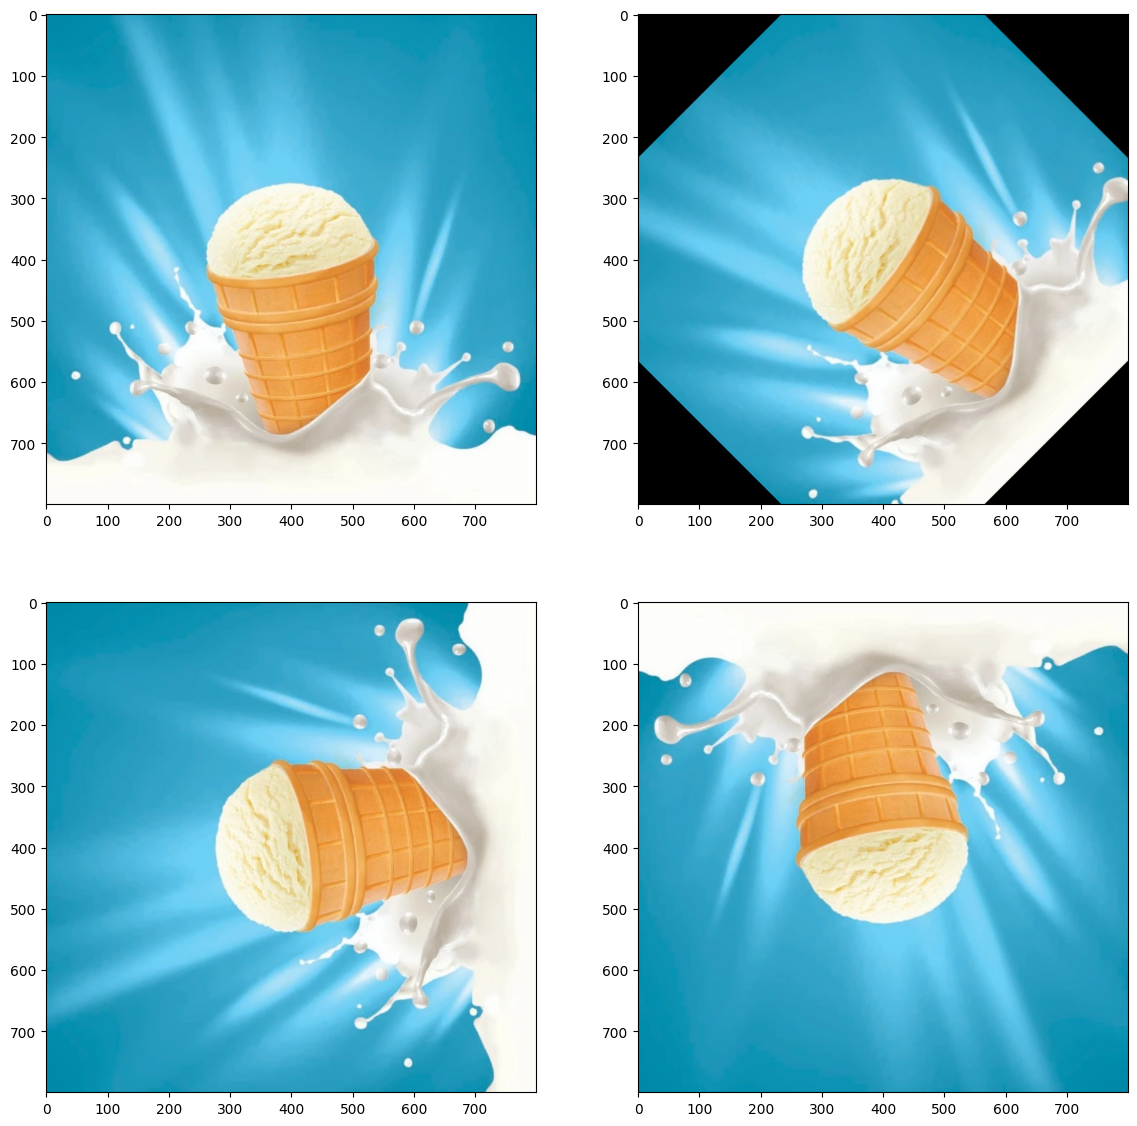

In [6]:
rgb_img_1, img_rotated_45_1, img_rotated_90_1, img_rotated_180_1 = get_imgs("whale.jpg")
calc_metrics(rgb_img_1, img_rotated_45_1, img_rotated_90_1, img_rotated_180_1)


# №2

In [7]:
rgb_img_2, img_rotated_45_2, img_rotated_90_2, img_rotated_180_2 = get_imgs("elephant.jpg")
calc_metrics(rgb_img_2, img_rotated_45_2, img_rotated_90_2, img_rotated_180_2)

Output hidden; open in https://colab.research.google.com to view.

# №3


  HOG до модификаций:
  L1 между изобр и повернутым на 45 градусов: 68237.67;
  L2 между изобр и повернутым на 45 градусов: 195.49;
  L1 между изобр и повернутым на 90 градусов: 70944.83;
  L2 между изобр и повернутым на 90 градусов: 199.02;
  L1 между изобр и повернутым на 180 градусов: 77592.82;
  L2 между изобр и повернутым на 180 градусов: 211.68;

  HOG после модификаций:
  L1 между изобр и повернутым на 45 градусов: 8792.27;
  L2 между изобр и повернутым на 45 градусов: 26.76;
  L1 между изобр и повернутым на 90 градусов: 239.68;
  L2 между изобр и повернутым на 90 градусов: 1.62;
  L1 между изобр и повернутым на 180 градусов: 414.73;
  L2 между изобр и повернутым на 180 градусов: 2.43;
  


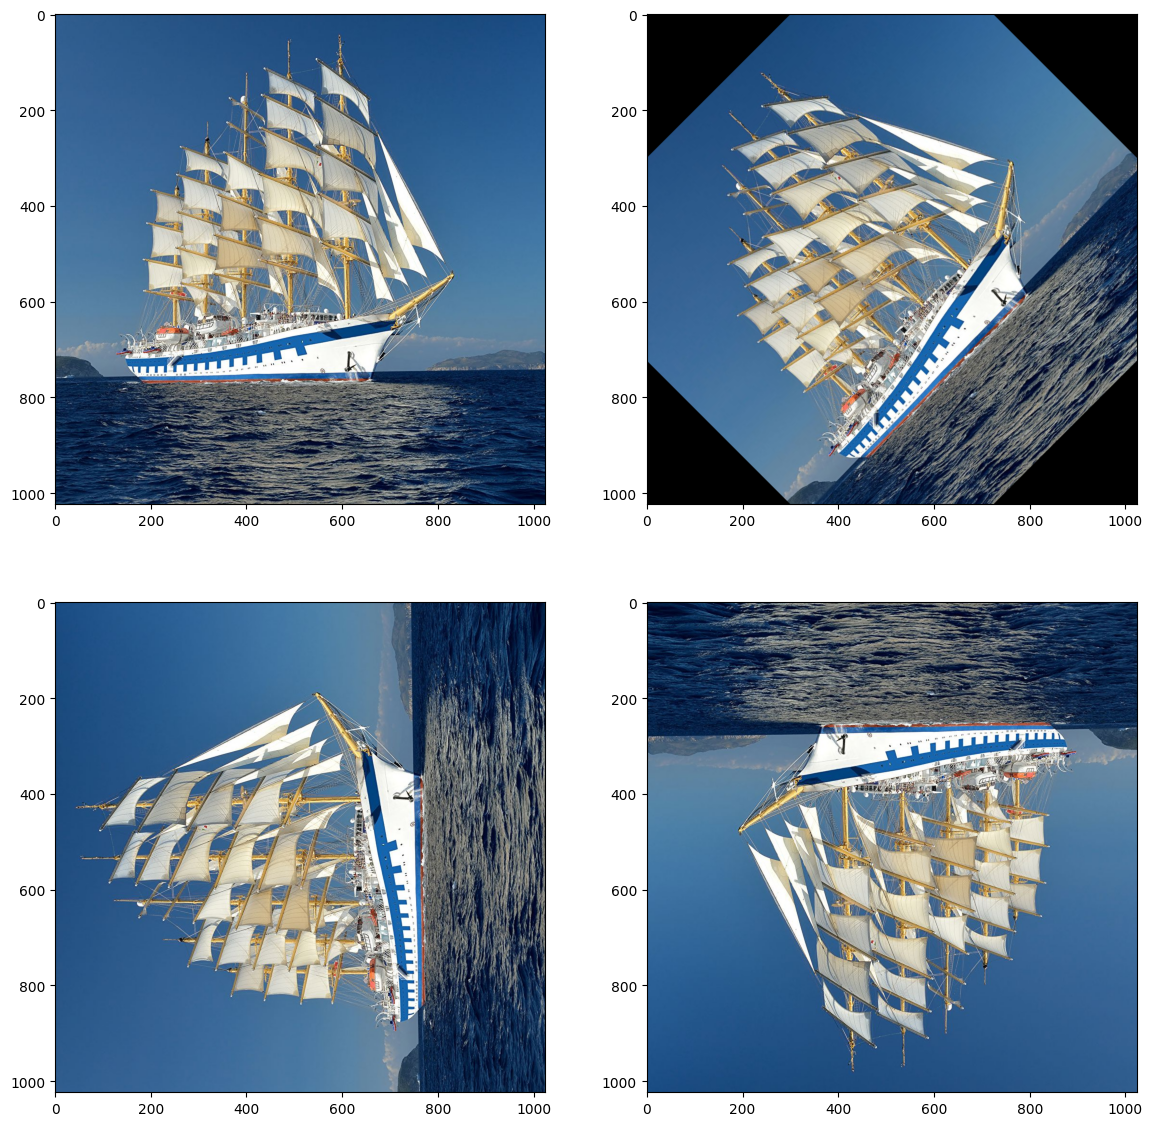

In [8]:
rgb_img_3, img_rotated_45_3, img_rotated_90_3, img_rotated_180_3 = get_imgs("ship.jpg")
calc_metrics(rgb_img_3, img_rotated_45_3, img_rotated_90_3, img_rotated_180_3)